In [96]:
# ---------------------------------------------------------
# EDA 
# ---------------------------------------------------------
# Imports 
import json  
import zipfile  

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split



%matplotlib inline 


# That Data
df = pd.read_json('../data.json')
# df.head()

# Make fraud column 
df['fraud'] = df.acct_type.apply(lambda x: 1 if 'fraud' in x else 0)

# Get columns 
columns = list(df.columns)

# See What they looks like 
# df.info()

# Get missing varaiabels 
missing_values = []
for col in columns:
    if df[col].isna().any():
        missing_values.append(col)
        
print(f'Number: {len(missing_values)} \n\nVariables with missing values:\n{missing_values}')

# get variabels by type 
var_floats = []
var_ints = []
var_objects = []

for col in columns:
    if df[col].dtype == 'int64':
        var_ints.append(col)
    elif df[col].dtype == 'float64':
        var_floats.append(col)
    else:
        var_objects.append(col)

print(f' Floats: {var_floats} \n\n Ints: {var_ints} \n\n Objects: {var_objects}')

Number: 12 

Variables with missing values:
['country', 'delivery_method', 'event_published', 'has_header', 'org_facebook', 'org_twitter', 'sale_duration', 'venue_country', 'venue_latitude', 'venue_longitude', 'venue_name', 'venue_state']
 Floats: ['delivery_method', 'event_published', 'gts', 'has_header', 'org_facebook', 'org_twitter', 'sale_duration', 'venue_latitude', 'venue_longitude'] 

 Ints: ['approx_payout_date', 'body_length', 'channels', 'event_created', 'event_end', 'event_start', 'fb_published', 'has_analytics', 'has_logo', 'name_length', 'num_order', 'num_payouts', 'object_id', 'sale_duration2', 'show_map', 'user_age', 'user_created', 'user_type', 'fraud'] 

 Objects: ['acct_type', 'country', 'currency', 'description', 'email_domain', 'listed', 'name', 'org_desc', 'org_name', 'payee_name', 'payout_type', 'previous_payouts', 'ticket_types', 'venue_address', 'venue_country', 'venue_name', 'venue_state']


In [118]:
columns = list(df.columns)
columns


# user_age - if they appear twice, their first event will still show up
# as their age now. Change it to not be final age, (day event - users first date)

['acct_type',
 'approx_payout_date',
 'body_length',
 'channels',
 'country',
 'currency',
 'delivery_method',
 'description',
 'email_domain',
 'event_created',
 'event_end',
 'event_published',
 'event_start',
 'fb_published',
 'gts',
 'has_analytics',
 'has_header',
 'has_logo',
 'listed',
 'name',
 'name_length',
 'num_order',
 'num_payouts',
 'object_id',
 'org_desc',
 'org_facebook',
 'org_name',
 'org_twitter',
 'payee_name',
 'payout_type',
 'previous_payouts',
 'sale_duration',
 'sale_duration2',
 'show_map',
 'ticket_types',
 'user_age',
 'user_created',
 'user_type',
 'venue_address',
 'venue_country',
 'venue_latitude',
 'venue_longitude',
 'venue_name',
 'venue_state',
 'fraud',
 'mask_previous_payout']

In [97]:
# X is features, y is target. Returns a cross tab of predicted 
# and actual values for fraud vs not fraud
def get_crosstab(X, y, model_type):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
    model = model_type
    model.fit(Xtrain, ytrain)
    print(model.predict_proba(Xtest))
    predicted = model.predict(Xtest)
    actual = ytest
    crosstab = pd.crosstab(ytest, model.predict(Xtest), rownames=['actual'], colnames=['predicted'])
    return model, crosstab

In [113]:
from sklearn.linear_model import LogisticRegression

mask = df.previous_payouts.apply(lambda x: 0 if len(x) <= 0 else 1)
df['mask_previous_payout'] = mask
X = df[['mask_previous_payout', 'user_age']]
y = df['fraud'].apply(lambda x: 'Fraud' if x == 1 else 'Not')

# get predict proba from both models, for each data point take average 
# probabilities. probs set at .5 by default

model, crosstab = get_crosstab(X, y, LogisticRegression())
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
model
crosstab
df['user_age']

[[0.01600578 0.98399422]
 [0.01065795 0.98934205]
 [0.03447242 0.96552758]
 ...
 [0.02996302 0.97003698]
 [0.01585147 0.98414853]
 [0.03447242 0.96552758]]


0          36
1         149
2         214
3         889
4          35
         ... 
14332       0
14333    1374
14334      84
14335     812
14336       0
Name: user_age, Length: 14337, dtype: int64

In [99]:
# make predictions with a given model, setting the threshold to 
# a probability of you choice between (0, 1)
def predict(model, X, threshold=0.5):
    '''Return prediction of the fitted binary-classifier model model on X using
    the specifed `threshold`. NB: class 0 is the positive class'''
#     print(np.where(model.predict_proba(X)[:, 0] > threshold,
#                     model.classes_[0],
#                     model.classes_[1]))
    return np.where(model.predict_proba(X)[:, 0] > threshold,
                    model.classes_[0],
                    model.classes_[1])

# create confusion matrix with a given model and Xtest

def confusion_matrix(model, X, threshold=0.5):
    # write own instead of deal with crosstab
    cf = pd.crosstab(ytest, predict(model, Xtest, threshold), dropna=False)
#     print(cf)
    cf = cf.add(pd.DataFrame([[0,0],[0,0]], columns=['Fraud', 'Not'], index=['Fraud', 'Not']), fill_value=0)
    cf.index.name = 'actual'
    cf.columns.name = 'predicted'
    return cf

# manually do this with predic proba. for every threshhold, manually 
# calculate what would be predicted fraud/not fraud. Manually
# calculate true vs false positives

Text(0.5, 1.0, 'Profit Curve')

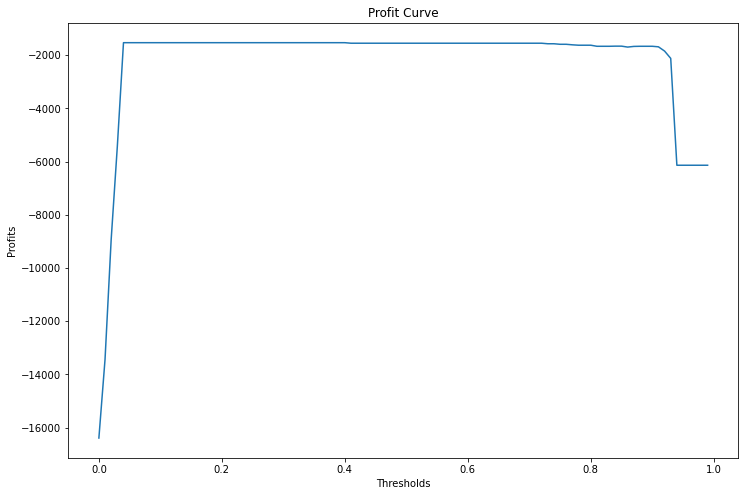

In [100]:
# ROC curve 
# has logo, has header (both are binaries)

# predicted not fraud but it is -$20
# predicted fraud but it isn't -$5
# true positive catching a fraud $0 ?
# true positive catching a not fraud $0
import numpy as np

cb_matrix = pd.DataFrame([[0, -20], [-5, 0]], columns=["Fraud", "Not"], index=["Fraud", "Not"])
cb_matrix.index.name = 'actual'
cb_matrix.columns.name = 'predicted'
cb_matrix

# calculate the payout with a the cost benefit matrix, 
# given threshhold, model, and X
def calculate_payout(cb_matrix, model, X, threshold):
    return (confusion_matrix(model, X, threshold) * cb_matrix).values.sum()
    
thresholds = np.arange(0.0, 1.0, 0.01)
profits = []
for threshold in thresholds:
    profits.append(calculate_payout(cb_matrix, model, X, threshold))

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(thresholds, profits)
ax.set_xlabel('Thresholds')
ax.set_ylabel('Profits')
ax.set_title('Profit Curve')



In [49]:
# X = df[['mask_previous_payout', 'user_age', 'has_logo', 'has_header']]
# 
# get_crosstab(X, y, DecisionTreeClassifier())
# from sklearn.tree import DecisionTreeClassifier
# get_crosstab(X, y, DecisionTreeClassifier())
crosstab

1

In [71]:
cb_matrix

predicted,Fraud,Not
actual,,
Fraud,0,-20
Not,-5,0


In [114]:

# ---------------------------------------------------------------------------
# Pipeline Funtions 
# ---------------------------------------------------------------------------
def not_premium(x):
    return 1 if x.lower() != 'premium' else 0

def no_previous_payout(x):
    return 1 if len(x) <= 0 else 0

def payout_name_flag(x):
    for d in x:
        if len(d['name']) > 3:
            return 1
    return 0

def payout_toself(payee, payouts):
    for pay in payouts:
        if payee.lower() in pay['name'].lower():
            return 1
    return 0

# ---------------------------------------------------------------------------
# End Funtions 
# ---------------------------------------------------------------------------
# 'premium': df.acct_type.apply(lambda x: not_premium(x)),
temp = dict()
temp = {'target': df['fraud'].copy(), 
        'previous_payout': df.previous_payouts.apply(lambda x: no_previous_payout(x)),
        'no_payout_name': df.previous_payouts.apply(lambda x: payout_name_flag(x)),
        'payout_toself': df.apply(lambda x: payout_toself(x.payee_name, x.previous_payouts), axis = 1)
       }

df_model = pd.DataFrame(temp)

In [115]:
X = df_model.drop('target', axis = 1)
y = df_model['target']

In [116]:
get_crosstab(X, y, LogisticRegression())

[[0.97267806 0.02732194]
 [0.97267806 0.02732194]
 [0.97267806 0.02732194]
 ...
 [0.97267806 0.02732194]
 [0.97267806 0.02732194]
 [0.98878235 0.01121765]]


(LogisticRegression(),
 predicted     0    1
 actual              
 0          3235   14
 1            75  261)

In [112]:
# Fraud	248	70
# Not	24	3243
y.value_counts()


Not      13044
Fraud     1293
Name: fraud, dtype: int64